In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:

# import package
from __future__ import print_function, division
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models, utils
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils for writing own dataset
import time
import copy


import pandas as pd
from skimage import io, transform
import numpy as np

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

IMG_SIZE  = (224,224) # image size of efficient net

# 1. 데이터셋 불러오기
데이터셋은 torchvision 패키지에서 제공하는 STL10 dataset을 이용하겠습니다. STL10 dataset은 10개의 label을 갖으며 train dataset 5000개, test dataset 8000개로 구성됩니다.

WRITING CUSTOM DATASETS, DATALOADERS AND TRANSFORMS

Reading Annotations (groud truth)

In [ ]:
# specify path to data
path2data = 'data/train/'

train_gt_data_all = pd.read_csv(path2data + 'new_train_output_seomjingang.csv')

# get all timestamps
gt_timestamps = train_gt_data_all['관측시간']
gt_timestamps = list(dict.fromkeys(gt_timestamps)) # remove duplicates
gt_timestamps = [gt_timestamps[i].replace('-', '').replace(' ', '') + '00' for i in range(len(gt_timestamps))]

In [ ]:
print(gt_timestamps[0:5])

In [ ]:
# Get GPM, RR, TPW
import xarray as xr
import glob
%matplotlib inline

filenames_dict = dict() # {timestamp: [list of files]}

def filter_by_timestamp(original_list, f_dict):
    new_list = []
    for timestamp in gt_timestamps:
        for i in range(len(original_list)):
            if timestamp in original_list[i]:
                new_list.append(original_list[i])
                if timestamp not in f_dict.keys():
                    f_dict[timestamp] = [original_list[i]]
                else:
                    f_dict[timestamp].append(original_list[i])
                break
    return new_list

def gpm_filter_by_timestamp(original_list, f_dict):
    new_list = []
    for timestamp in gt_timestamps:
        for i in range(len(original_list)):
            if timestamp[0:8] in original_list[i] and 'S'+timestamp[8:13] in original_list[i] :
                new_list.append(original_list[i])
                if timestamp not in f_dict.keys():
                    f_dict[timestamp] = [original_list[i]]
                else:
                    f_dict[timestamp].append(original_list[i])
                break
    return new_list

# GPM
#!pip install rasterio
gpm_file_list = glob.glob("data/train/input_nasa_gpm/*.tif")
# only retrive files matching the timestamp
gpm_file_list = gpm_filter_by_timestamp(gpm_file_list, filenames_dict)
#gpm_dset_all = [xr.open_rasterio(gpm_file_list[i]) for i in range(len(gpm_file_list))]
#gpm_images = [gpm_dset_all[i].to_dataset('band').rename({1: 'red'}).red.values for i in range(len(gpm_file_list))]

# TPW 
# get all *.nc files
valid_max = 10000
tpw_file_list = glob.glob("E:\ai_factory\tpw\work*.nc")
tpw_file_list = filter_by_timestamp(tpw_file_list, filenames_dict)
#tpw_dset_all = [xr.open_dataset(tpw_file_list[i]) for i in range(len(tpw_file_list))]
#tpw_images = [tpw_dset_all[i]['TPW'].values / valid_max for i in range(len(tpw_dset_all))]

# RR 
# get all *.nc files
rr_file_list = glob.glob("E:\ai_factory\tpw\work*.nc")
rr_file_list = filter_by_timestamp(rr_file_list, filenames_dict)
#rr_dset_all = [xr.open_dataset(rr_file_list[i]) for i in range(len(rr_file_list))]
#rr_images = [rr_dset_all[i]['RR'].values / valid_max for i in range(len(rr_dset_all))]

#train_file_list_only_names = [train_file_list[i][train_file_list[i].find("train/")+6:] for i in range(len(train_file_list))]
#print(train_file_list_only_names)


In [ ]:
# Convert to a single image
time_image_dict = dict()

IMG_SIZE  = (224, 224) # image size of efficient net
valid_max = 100.
scale = 10.
train_images = []
for k in filenames_dict.keys():
    img_filename_list = filenames_dict[k]
    if (len(img_filename_list) == 3):
        gpm_img = np.array([])
        tpw_img = np.array([])
        rr_img = np.array([])
        for filename in img_filename_list:
            if 'HHR' in filename:
                temp = xr.open_rasterio(filename).to_dataset('band').rename({1: 'red'}).red.values * 10
                gpm_img = temp.copy()
                gpm_img.resize(IMG_SIZE)
            if 'tpw' in filename:
                temp = xr.open_dataset(filename)['TPW'].values / valid_max
                tpw_img = temp.copy()
                tpw_img.resize(IMG_SIZE)
            if 'rr' in filename:
                temp = xr.open_dataset(filename)['RR'].values / valid_max
                rr_img = temp.copy()
                rr_img.resize(IMG_SIZE)
        #print("gpm size: ", gpm_img.shape)
        #print("tpw size: ", tpw_img.shape)
        #print("rr size: ", rr_img.shape)
        stacked_image = np.dstack((tpw_img, rr_img, gpm_img))
        time_image_dict[k] = stacked_image
        train_images.append(stacked_image)
#print(time_image_dict.keys())

In [ ]:
# Save converted files to .npy
save_as_npy = False
if (save_as_npy):
    path2data = '/content/gdrive/MyDrive/data/'
    with open(path2data + 'gpm_images.npy', 'wb') as f:
        np.save(f, gpm_images)
    with open(path2data + 'tpw_images.npy', 'wb') as f:
        np.save(f, tpw_images)
    with open(path2data + 'rr_images.npy', 'wb') as f:
        np.save(f, rr_images)

In [2]:
# load from npy
time_image_dict = np.load('C:/Users/GomZoo/Downloads/rgb_images.npy', allow_pickle=True)
time_image_dict = time_image_dict[()]
type(time_image_dict)

dict

Data structure is as follows:
image_name, 년월일시, 도통리 시강수량, 용암리 시강수량, 시산리 시강수량, 섬진강댐 시강수량, 복내리 시강수량, 주암댐 시강수량, 동가리 시강수량, 맹리 시강수량, 우산리 시강수량, 동복댐 시강수량, 봉동리 시강수량, 보성강댐 시강수량



In [3]:
class SeomjingangDataset(Dataset):
    """Seomjingang dataset."""

    def __init__(self, csv_file, root_dir, time_image_dict, transform=None):
        """
        Converts csv data into N x 12 (no of observatories) ordered by time with image names added
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            n (int): Number of data entries to use.
            image_names (list): List of file names (timestamps) that will be added to the ground truth data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.train_gt_data_all = pd.read_csv(root_dir + "/" + csv_file)
        #self.train_gt_data = train_gt_data_all.head(n)
        print("image_dict length", len(time_image_dict.keys()))
        self.train_data = self.train_gt_data_all.pivot(index="관측시간", columns="관측소명", values="시강수량")
        print("image_dict length", len(self.train_data))
        self.train_data = self.train_data.head(len(time_image_dict.keys()))
        self.train_data.insert(0, "image_name", time_image_dict.keys())
        self.root_dir = root_dir
        self.time_image_dict = time_image_dict
        self.transform = transform

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_name = self.train_data.iloc[idx, 0]
        tpw_image = self.time_image_dict[image_name]
        tpws = self.train_data.iloc[idx, 1:]
        tpws = np.array([tpws])
        tpws = tpws.astype('float')
        sample = {'image': tpw_image, 'hourly_rainfall': tpws}

        if self.transform:
            sample = self.transform(sample)

        return sample
        
    def convertNC2img(self, nc_file_name):
        max_tpw = 10000 # 10000 is the max_tpw
        #nc_files_all = [xr.open_dataset(self.root_dir + nc_file_list[i]) for i in range(len(nc_file_list))]
        #tpw_images = [nc_files_all[i]['TPW'].values / max_tpw for i in range(len(nc_file_list))] 
        nc_file = xr.open_dataset(self.root_dir + "/" + nc_file_name)
        tpw_image = nc_file['TPW'].values / max_tpw 
        return tpw_image


image_dict length 11498
image_dict length 11664
image_dict length 11498
image_dict length 11664
0 (224, 224, 3) (1, 12)


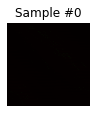

1 (224, 224, 3) (1, 12)


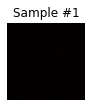

2 (224, 224, 3) (1, 12)


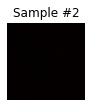

3 (224, 224, 3) (1, 12)


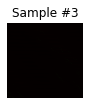

In [4]:

sjg_train_dataset = SeomjingangDataset(csv_file='new_train_output_seomjingang.csv',
                                 root_dir='data/train/',
                                 time_image_dict = time_image_dict)
sjg_val_dataset = SeomjingangDataset(csv_file='new_train_output_seomjingang.csv',
                                 root_dir='data/train/',
                                 time_image_dict = time_image_dict)

# check dataset
fig = plt.figure()

def show_tpw(image):
    """Show image tpw"""
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

print(sjg_train_dataset)
for i in range(len(sjg_train_dataset)):
    sample = sjg_train_dataset[i]

    print(i, sample['image'].shape, sample['hourly_rainfall'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_tpw(sample['image'])

    if i == 3:
        plt.show()
        break

In [5]:
# Transform image to make it fit to efficientNet
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, tpws = sample['image'], sample['hourly_rainfall']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'hourly_rainfall': tpws}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, tpws = sample['image'], sample['hourly_rainfall']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'hourly_rainfall': torch.from_numpy(tpws)}

In [6]:

sjg_train_dataset = SeomjingangDataset(csv_file='new_train_output_seomjingang.csv',
                                 root_dir='data/train/',
                                 time_image_dict = time_image_dict,
                                 transform=transforms.Compose([
                                               Rescale(224),
                                               ToTensor()
                                           ]))
sjg_val_dataset = SeomjingangDataset(csv_file='new_train_output_seomjingang.csv',
                                 root_dir='data/train/',
                                 time_image_dict = time_image_dict,
                                 transform=transforms.Compose([
                                               Rescale(224),
                                               ToTensor()
                                           ]))
for i in range(len(sjg_train_dataset)):
    sample = sjg_train_dataset[i]

    print(i, sample['image'].size(), sample['hourly_rainfall'].size())

    if i == 3:
        break

image_dict length 11498
image_dict length 11664
image_dict length 11498
image_dict length 11664
0 torch.Size([3, 224, 224]) torch.Size([1, 12])
1 torch.Size([3, 224, 224]) torch.Size([1, 12])
2 torch.Size([3, 224, 224]) torch.Size([1, 12])
3 torch.Size([3, 224, 224]) torch.Size([1, 12])


In [10]:
# load dataset
#torch.cuda.empty_cache()
N = len(sjg_train_dataset)
N_split = int(N * 0.7)

# Random split
train_set_size = int(len(sjg_train_dataset) * 0.7)
valid_set_size = len(sjg_train_dataset) - train_set_size
indices = list(range(N))

train_idx, valid_idx = indices[:train_set_size], indices[train_set_size:]
train_set = torch.utils.data.Subset(sjg_train_dataset, train_idx)
valid_set = torch.utils.data.Subset(sjg_train_dataset, valid_idx)

# make dataloader
train_dl = DataLoader(train_set, batch_size=16, shuffle=True)
val_dl = DataLoader(valid_set, batch_size=16, shuffle=True)

# 2. 모델 구축하기
코드는 https://github.com/zsef123/EfficientNets-PyTorch/blob/master/models/effnet.py 를 참고했습니다.

https://github.com/katsura-jp/efficientnet-pytorch/blob/master/model/efficientnet.py

In [11]:
# Swish activation function
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

# check
if __name__ == '__main__':
    x = torch.randn(3, 3, 224, 224)
    model = Swish()
    output = model(x)
    print('output size:', output.size())

output size: torch.Size([3, 3, 224, 224])


In [12]:
# SE Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, r=4):
        super().__init__()

        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels * r),
            Swish(),
            nn.Linear(in_channels * r, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1)
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return x

# check
if __name__ == '__main__':
    x = torch.randn(3, 56, 17, 17)
    model = SEBlock(x.size(1))
    output = model(x)
    print('output size:', output.size())

output size: torch.Size([3, 56, 1, 1])


In [13]:
class MBConv(nn.Module):
    expand = 6
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        # first MBConv is not using stochastic depth
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * MBConv.expand, 1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish(),
            nn.Conv2d(in_channels * MBConv.expand, in_channels * MBConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*MBConv.expand),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * MBConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*MBConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # stochastic depth
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x

# check
if __name__ == '__main__':
    x = torch.randn(3, 16, 24, 24)
    model = MBConv(x.size(1), x.size(1), 3, stride=1, p=1)
    model.train()
    output = model(x)
    x = (output == x)
    print('output size:', output.size(), 'Stochastic depth:', x[1,0,0,0])


output size: torch.Size([3, 16, 24, 24]) Stochastic depth: tensor(False)


In [14]:
class SepConv(nn.Module):
    expand = 1
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        # first SepConv is not using stochastic depth
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels * SepConv.expand, in_channels * SepConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*SepConv.expand),
            nn.BatchNorm2d(in_channels * SepConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * SepConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*SepConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # stochastic depth
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x

# check
if __name__ == '__main__':
    x = torch.randn(3, 16, 24, 24)
    model = SepConv(x.size(1), x.size(1), 3, stride=1, p=1)
    model.train()
    output = model(x)
    # stochastic depth check
    x = (output == x)
    print('output size:', output.size(), 'Stochastic depth:', x[1,0,0,0])

output size: torch.Size([3, 16, 24, 24]) Stochastic depth: tensor(False)


In [15]:
# class EfficientNet(nn.Module):
#     def __init__(self, num_classes=10, width_coef=1., depth_coef=1., scale=1., dropout=0.2, se_scale=4, stochastic_depth=False, p=0.5):
#         super().__init__()
#         channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
#         repeats = [1, 2, 2, 3, 3, 4, 1]
#         strides = [1, 2, 2, 2, 1, 2, 1]
#         kernel_size = [3, 3, 5, 3, 5, 5, 3]
#         depth = depth_coef
#         width = width_coef

#         channels = [int(x*width) for x in channels]
#         repeats = [int(x*depth) for x in repeats]

#         # stochastic depth
#         if stochastic_depth:
#             self.p = p
#             self.step = (1 - 0.5) / (sum(repeats) - 1)
#         else:
#             self.p = 1
#             self.step = 0


#         # efficient net
#         self.upsample = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False)

#         self.stage1 = nn.Sequential(
#             nn.Conv2d(3, channels[0],3, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(channels[0], momentum=0.99, eps=1e-3)
#         )

#         self.stage2 = self._make_Block(SepConv, repeats[0], channels[0], channels[1], kernel_size[0], strides[0], se_scale)

#         self.stage3 = self._make_Block(MBConv, repeats[1], channels[1], channels[2], kernel_size[1], strides[1], se_scale)

#         self.stage4 = self._make_Block(MBConv, repeats[2], channels[2], channels[3], kernel_size[2], strides[2], se_scale)

#         self.stage5 = self._make_Block(MBConv, repeats[3], channels[3], channels[4], kernel_size[3], strides[3], se_scale)

#         self.stage6 = self._make_Block(MBConv, repeats[4], channels[4], channels[5], kernel_size[4], strides[4], se_scale)

#         self.stage7 = self._make_Block(MBConv, repeats[5], channels[5], channels[6], kernel_size[5], strides[5], se_scale)

#         self.stage8 = self._make_Block(MBConv, repeats[6], channels[6], channels[7], kernel_size[6], strides[6], se_scale)

#         self.stage9 = nn.Sequential(
#             nn.Conv2d(channels[7], channels[8], 1, stride=1, bias=False),
#             nn.BatchNorm2d(channels[8], momentum=0.99, eps=1e-3),
#             Swish()
#         ) 

#         self.avgpool = nn.AdaptiveAvgPool2d((1,1))
#         self.dropout = nn.Dropout(p=dropout)
#         #self.linear = nn.Linear(channels[8], num_classes) # TODO: change here to 1?
#         self.linear = nn.Linear(channels[8], 12)

#     def forward(self, x):
#         x = self.upsample(x)
#         x = self.stage1(x)
#         x = self.stage2(x)
#         x = self.stage3(x)
#         x = self.stage4(x)
#         x = self.stage5(x)
#         x = self.stage6(x)
#         x = self.stage7(x)
#         x = self.stage8(x)
#         x = self.stage9(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.dropout(x)
#         x = self.linear(x)
#         return x


#     def _make_Block(self, block, repeats, in_channels, out_channels, kernel_size, stride, se_scale):
#         strides = [stride] + [1] * (repeats - 1)
#         layers = []
#         for stride in strides:
#             layers.append(block(in_channels, out_channels, kernel_size, stride, se_scale, self.p))
#             in_channels = out_channels
#             self.p -= self.step

#         return nn.Sequential(*layers)


# def efficientnet_b0(num_classes=10):
#     return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.0, scale=1.0,dropout=0.2, se_scale=4)

# def efficientnet_b1(num_classes=10):
#     return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.1, scale=240/224, dropout=0.2, se_scale=4)

# def efficientnet_b2(num_classes=10):
#     return EfficientNet(num_classes=num_classes, width_coef=1.1, depth_coef=1.2, scale=260/224., dropout=0.3, se_scale=4)

# def efficientnet_b3(num_classes=10):
#     return EfficientNet(num_classes=num_classes, width_coef=1.2, depth_coef=1.4, scale=300/224, dropout=0.3, se_scale=4)

# def efficientnet_b4(num_classes=10):
#     return EfficientNet(num_classes=num_classes, width_coef=1.4, depth_coef=1.8, scale=380/224, dropout=0.4, se_scale=4)

# def efficientnet_b5(num_classes=10):
#     return EfficientNet(num_classes=num_classes, width_coef=1.6, depth_coef=2.2, scale=456/224, dropout=0.4, se_scale=4)

# def efficientnet_b6(num_classes=10):
#     return EfficientNet(num_classes=num_classes, width_coef=1.8, depth_coef=2.6, scale=528/224, dropout=0.5, se_scale=4)

# def efficientnet_b7(num_classes=10):
#     return EfficientNet(num_classes=num_classes, width_coef=2.0, depth_coef=3.1, scale=600/224, dropout=0.5, se_scale=4)


# # check
# if __name__ == '__main__':
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     x = torch.randn(3, 3, 224, 224).to(device)
#     model = efficientnet_b0().to(device)
#     output = model(x)
#     print('output size:', output.size())

In [16]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes=10, width_coef=1., depth_coef=1., scale=1., dropout=0.2, se_scale=4, stochastic_depth=False, p=0.5):
        super().__init__()
        channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
        repeats = [1, 2, 2, 3, 3, 4, 1]
        strides = [1, 2, 2, 2, 1, 2, 1]
        kernel_size = [3, 3, 5, 3, 5, 5, 3]
        depth = depth_coef
        width = width_coef

        channels = [int(x*width) for x in channels]
        repeats = [int(x*depth) for x in repeats]

        # stochastic depth
        if stochastic_depth:
            self.p = p
            self.step = (1 - 0.5) / (sum(repeats) - 1)
        else:
            self.p = 1
            self.step = 0


        # efficient net
        self.upsample = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False)

        self.stage1 = nn.Sequential(
            nn.Conv2d(3, channels[0],3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(channels[0], momentum=0.99, eps=1e-3)
        )

        self.stage2 = self._make_Block(SepConv, repeats[0], channels[0], channels[1], kernel_size[0], strides[0], se_scale)

        self.stage3 = self._make_Block(MBConv, repeats[1], channels[1], channels[2], kernel_size[1], strides[1], se_scale)

        self.stage4 = self._make_Block(MBConv, repeats[2], channels[2], channels[3], kernel_size[2], strides[2], se_scale)

        self.stage5 = self._make_Block(MBConv, repeats[3], channels[3], channels[4], kernel_size[3], strides[3], se_scale)

        self.stage6 = self._make_Block(MBConv, repeats[4], channels[4], channels[5], kernel_size[4], strides[4], se_scale)

        self.stage7 = self._make_Block(MBConv, repeats[5], channels[5], channels[6], kernel_size[5], strides[5], se_scale)

        self.stage8 = self._make_Block(MBConv, repeats[6], channels[6], channels[7], kernel_size[6], strides[6], se_scale)

        self.stage9 = nn.Sequential(
            nn.Conv2d(channels[7], channels[8], 1, stride=1, bias=False),
            nn.BatchNorm2d(channels[8], momentum=0.99, eps=1e-3),
            Swish()
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=dropout)
        #self.linear = nn.Linear(channels[8], num_classes) # TODO: change here to 1?
        self.linear = nn.Linear(channels[8], 12)

    def forward(self, x):
        x = self.upsample(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.stage8(x)
        x = self.stage9(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        x = x.unsqueeze(0)
        return x


    def _make_Block(self, block, repeats, in_channels, out_channels, kernel_size, stride, se_scale):
        strides = [stride] + [1] * (repeats - 1)
        layers = []
        for stride in strides:
            layers.append(block(in_channels, out_channels, kernel_size, stride, se_scale, self.p))
            in_channels = out_channels
            self.p -= self.step

        return nn.Sequential(*layers)


def efficientnet_b0(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.0, scale=1.0,dropout=0.2, se_scale=4)

def efficientnet_b1(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.1, scale=240/224, dropout=0.2, se_scale=4)

def efficientnet_b2(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.1, depth_coef=1.2, scale=260/224., dropout=0.3, se_scale=4)

def efficientnet_b3(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.2, depth_coef=1.4, scale=300/224, dropout=0.3, se_scale=4)

def efficientnet_b4(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.4, depth_coef=1.8, scale=380/224, dropout=0.4, se_scale=4)

def efficientnet_b5(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.6, depth_coef=2.2, scale=456/224, dropout=0.4, se_scale=4)

def efficientnet_b6(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.8, depth_coef=2.6, scale=528/224, dropout=0.5, se_scale=4)

def efficientnet_b7(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=2.0, depth_coef=3.1, scale=600/224, dropout=0.5, se_scale=4)

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
       
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
       
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
       
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
       
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
       
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
       
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
       
        out = self.fc(h_out)
       
        return out

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
       
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 = nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer
        self.relu = nn.ReLU()
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state
        # Propagate input through LSTM
       
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
       
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
       
        return out
   
from torch.autograd import Variable
# check
if __name__ == '__main__':
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    x = torch.randn(3, 3, 224, 224).to(device)
    input_size = 12 #number of features
    hidden_size = 4 #number of features in hidden state
    num_layers = 2 #number of stacked lstm layers

    num_classes = 12 #number of output classes
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers, x).to(device)
    model = efficientnet_b0().to(device)
    model2 = nn.Sequential(
        model,
        lstm
    )
    output = model2(x)
    print('output size:', output.size())

output size: torch.Size([2, 12])


In [17]:
# print model summary
model = efficientnet_b0().to(device)
#summary(model, (3,224,224), device=device.type)

# 3. 학습하기

In [18]:
# define loss function, optimizer, lr_scheduler
#loss_func = nn.CrossEntropyLoss(reduction='sum')
loss_func = nn.MSELoss(reduction='mean')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# this metric is for classification!
# calculate the metric per mini-batch
def metric_batch(output, target):
    # original function returns number of correct classification
    # by doing so, measures accuracy
    # instead, calculate how close each value is to target value,
    # check whether it is within some threshold
    # and count number of items within the threshold
    # threshold: parameter to fine-tune
    correct_threshold = 0.01; #TODO change this?
    
    diff = abs(output - target)
    corrects = torch.count_nonzero(diff.le(correct_threshold)).item()
    #pred = output.argmax(1, keepdim=True) # index of max value in output
    #corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target).float()
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for val in dataset_dl:
        xb = val['image']
        yb = torch.squeeze(val['hourly_rainfall']).float()
        xb = xb.to(device).float()
        yb = yb.to(device).float()
        output = model(xb).float()
        
        assert(output.shape == yb.shape, "shapes do not match!")

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [19]:
# define the training parameters
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
#createFolder('/content/drive/MyDrive/data/models')

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/99, current lr= 0.01
train loss: nan, val loss: nan, accuracy: 0.00, time: 2.7232 min
----------
Epoch 1/99, current lr= 0.01
train loss: nan, val loss: nan, accuracy: 0.00, time: 5.3136 min
----------
Epoch 2/99, current lr= 0.01


In [ ]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()